# **Klasifikasi Gerakan untuk Rehabilitasi Stroke Menggunakan LSTM**
Dataset yang akan digunakan adalah 10 video gerakan rehabilitasi untuk pasien stroke yang ditemukan di Internet.

Proyek ini bertujuan untuk mendeteksi gerakan ....

# **1. Import Library**

In [ ]:
pip install ultralytics opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\DELL\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
pip install tensorflow

^C
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\DELL\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\DELL\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/375.9 MB 645.7 kB/s eta 0:09:42
   ---------------------------------------- 0.5/375.9 MB 645.7 kB/s eta 0:09:42
   ---------------------------------------- 0.5/375.9 MB 645.7 kB/s eta 0:09:42
   ---------------------------------------- 0.8/375.9 MB 516.0 kB/s eta 0:12:07
   ---------------------------------------- 0.8/375.9 MB 516.0 kB/s eta 0:12:07
   ---------------------------------------- 1.0/375.9 MB 541.2 kB/s eta 0:11:33
   ---------------------------------------- 1.0/375.9 MB 541.2 kB/s eta 0:11:33
   ---------------------------------------- 1.0/375.9 MB 541.2 kB/s eta 0:11:33
   --

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import time
import seaborn as sns

from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import defaultdict, deque
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

ModuleNotFoundError: No module named 'tensorflow'

# **2. Memuat Dataset**

In [ ]:
# Setup Folders for Collection
DATA_PATH = 'MP_Data'
VIDEO_DIR = 'dataset_video' 
sequence_length = 30         # frame per sequence
stride = sequence_length      
augment_mirror    = True     # hanya untuk train video
test_video_idx  = -1         # video ke-berapa per kelas utk hold-out (-1 = terakhir)
RANDOM_SEED     = 42
TRAIN_VIDS, TEST_VIDS = {}, {}

actions = sorted([d for d in os.listdir(VIDEO_DIR)
                  if os.path.isdir(os.path.join(VIDEO_DIR,d))])
print('Kelas terdeteksi:', actions, '\n')

vid_dict = defaultdict(list)   # {action: [video_path, …]}
for act in actions:
    for f in sorted(os.listdir(os.path.join(VIDEO_DIR,act))):
        if f.lower().endswith(('.mp4','.mov','.avi','.mkv')):
            vid_dict[act].append(os.path.join(VIDEO_DIR,act,f))

Kelas terdeteksi: ['Angkat Pinggul', 'Kaki Kebelakang', 'Lutut Turun', 'Naikan Kepalan Kedepan', 'Rentangkan'] 



# **3. Exploratory Data Analysis (EDA)**

In [ ]:
print(os.listdir(VIDEO_DIR))

['Rentangkan', 'Naikan Kepalan Kedepan', 'Lutut Turun', 'Kaki Kebelakang', 'Angkat Pinggul']


In [ ]:
VIDEO_DIR = 'dataset_video'
len(os.listdir(VIDEO_DIR))

5

,action,video,fps,frames,duration
0,Angkat Pinggul,1.MOV,59.953704,259,4.320000
1,Angkat Pinggul,2.MOV,59.957326,281,4.686667
2,Angkat Pinggul,3.mp4,24.919779,146,5.858800
3,Angkat Pinggul,4.mp4,24.919583,149,5.979233
4,Angkat Pinggul,5.mp4,24.912027,202,8.108533
5,Angkat Pinggul,6.mp4,24.927840,114,4.573200
6,Kaki Kebelakang,1.MOV,59.954233,262,4.370000
7,Kaki Kebelakang,2.MOV,59.973580,227,3.785000
8,Kaki Kebelakang,3.MOV,59.972106,215,3.585000
9,Kaki Kebelakang,4.MOV,59.971028,207,3.451667


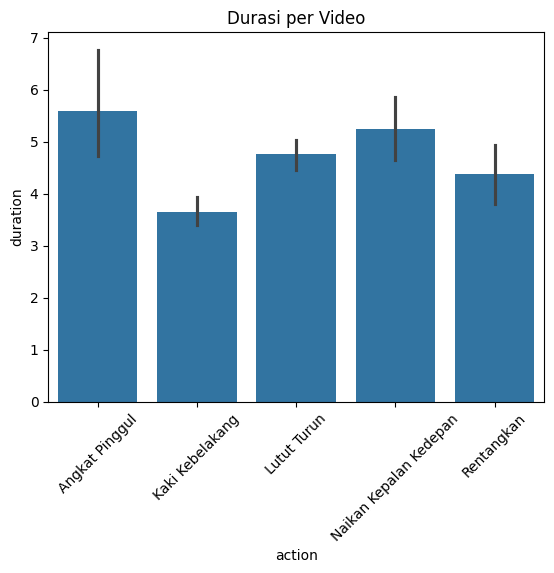

In [ ]:
rows=[]
for act in actions:
    for vp in vid_dict[act]:
        cap=cv2.VideoCapture(vp)
        fps  = cap.get(cv2.CAP_PROP_FPS) or 30
        nfrm = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        dur  = nfrm/fps
        rows.append(dict(action=act, video=os.path.basename(vp),
                         fps=fps, frames=nfrm, duration=dur))
        cap.release()
df=pd.DataFrame(rows)
display(df)
sns.barplot(data=df,x='action',y='duration')
plt.xticks(rotation=45); plt.title('Durasi per Video'); plt.show()

# **4. Preprocessing**

In [13]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm

# ---------------------------
# Inisialisasi Model YOLOv8
# ---------------------------
model = YOLO("yolov8n-pose.pt")  

# ---------------------------
# Pengaturan Folder
# ---------------------------
video_root = "dataset_video"  
keypoint_root = "keypoints"    

# Daftar aksi (label gerakan)
actions = ["Angkat Pinggul", "Kaki Kebelakang", "Lutut Turun", "Naikan Kepalan Kedepan", "Rentangkan"]

# ---------------------------
# Ekstraksi Keypoint
# ---------------------------
for action in actions:
    video_dir = os.path.join(video_root, action)
    save_dir = os.path.join(keypoint_root, action)
    os.makedirs(save_dir, exist_ok=True)

    for video_name in tqdm(os.listdir(video_dir), desc=f"Proses {action}"):
        video_path = os.path.join(video_dir, video_name)
        cap = cv2.VideoCapture(video_path)
        sequence = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            results = model.predict(source=frame, conf=0.5, save=False, verbose=False)
            keypoints = results[0].keypoints

            if keypoints is not None and len(keypoints.xy) > 0:
                # Ambil keypoint orang pertama
                kps = keypoints.xy[0].cpu().numpy()  # shape: (17, 2)
                if kps.shape[0] == 17:  # pastikan 17 keypoints
                    sequence.append(kps.flatten())  # shape: (34,) = 17 keypoints × 2 (x, y)

        cap.release()

        # Simpan hanya jika ada keypoint valid
        if len(sequence) > 0:
            try:
                sequence = np.array(sequence)  # shape: (n_frames, 34)
                save_path = os.path.join(save_dir, video_name.replace(".MOV", ".npy").replace(".mp4", ".npy"))
                np.save(save_path, sequence)
                print(f"✅ Keypoint disimpan: {save_path}")
            except ValueError as e:
                print(f"❌ Gagal menyimpan {video_name}: {e}")
        else:
            print(f"⚠️ Tidak ada keypoint di {video_name}")


Proses Angkat Pinggul:  17%|█▋        | 1/6 [00:50<04:12, 50.54s/it]

✅ Keypoint disimpan: keypoints\Angkat Pinggul\1.npy


Proses Angkat Pinggul:  33%|███▎      | 2/6 [01:44<03:30, 52.60s/it]

✅ Keypoint disimpan: keypoints\Angkat Pinggul\2.npy


Proses Angkat Pinggul:  50%|█████     | 3/6 [02:13<02:05, 41.92s/it]

✅ Keypoint disimpan: keypoints\Angkat Pinggul\3.npy


Proses Angkat Pinggul:  67%|██████▋   | 4/6 [02:42<01:13, 36.85s/it]

✅ Keypoint disimpan: keypoints\Angkat Pinggul\4.npy


Proses Angkat Pinggul:  83%|████████▎ | 5/6 [03:18<00:36, 36.26s/it]

✅ Keypoint disimpan: keypoints\Angkat Pinggul\5.npy


Proses Angkat Pinggul: 100%|██████████| 6/6 [03:36<00:00, 36.01s/it]


✅ Keypoint disimpan: keypoints\Angkat Pinggul\6.npy


Proses Kaki Kebelakang:  17%|█▋        | 1/6 [00:50<04:12, 50.44s/it]

✅ Keypoint disimpan: keypoints\Kaki Kebelakang\1.npy


Proses Kaki Kebelakang:  33%|███▎      | 2/6 [01:34<03:05, 46.41s/it]

✅ Keypoint disimpan: keypoints\Kaki Kebelakang\2.npy


Proses Kaki Kebelakang:  50%|█████     | 3/6 [02:12<02:08, 42.81s/it]

✅ Keypoint disimpan: keypoints\Kaki Kebelakang\3.npy


Proses Kaki Kebelakang:  67%|██████▋   | 4/6 [02:48<01:20, 40.12s/it]

✅ Keypoint disimpan: keypoints\Kaki Kebelakang\4.npy


Proses Kaki Kebelakang:  83%|████████▎ | 5/6 [03:27<00:39, 39.75s/it]

✅ Keypoint disimpan: keypoints\Kaki Kebelakang\5.npy


Proses Kaki Kebelakang: 100%|██████████| 6/6 [04:02<00:00, 40.38s/it]


✅ Keypoint disimpan: keypoints\Kaki Kebelakang\6.npy


Proses Lutut Turun:  17%|█▋        | 1/6 [00:56<04:40, 56.13s/it]

✅ Keypoint disimpan: keypoints\Lutut Turun\1.npy


Proses Lutut Turun:  33%|███▎      | 2/6 [01:46<03:31, 52.93s/it]

✅ Keypoint disimpan: keypoints\Lutut Turun\2.npy


Proses Lutut Turun:  50%|█████     | 3/6 [02:09<01:57, 39.09s/it]

✅ Keypoint disimpan: keypoints\Lutut Turun\3.npy


Proses Lutut Turun:  67%|██████▋   | 4/6 [02:31<01:04, 32.29s/it]

✅ Keypoint disimpan: keypoints\Lutut Turun\4.npy


Proses Lutut Turun:  83%|████████▎ | 5/6 [02:54<00:28, 28.98s/it]

✅ Keypoint disimpan: keypoints\Lutut Turun\5.npy


Proses Lutut Turun: 100%|██████████| 6/6 [03:11<00:00, 31.96s/it]


✅ Keypoint disimpan: keypoints\Lutut Turun\6.npy


Proses Naikan Kepalan Kedepan:  17%|█▋        | 1/6 [00:19<01:37, 19.48s/it]

✅ Keypoint disimpan: keypoints\Naikan Kepalan Kedepan\1.npy


Proses Naikan Kepalan Kedepan:  33%|███▎      | 2/6 [00:44<01:32, 23.00s/it]

✅ Keypoint disimpan: keypoints\Naikan Kepalan Kedepan\2.npy


Proses Naikan Kepalan Kedepan:  50%|█████     | 3/6 [01:07<01:08, 22.84s/it]

✅ Keypoint disimpan: keypoints\Naikan Kepalan Kedepan\3.npy


Proses Naikan Kepalan Kedepan:  67%|██████▋   | 4/6 [01:36<00:50, 25.34s/it]

✅ Keypoint disimpan: keypoints\Naikan Kepalan Kedepan\4.npy


Proses Naikan Kepalan Kedepan:  83%|████████▎ | 5/6 [02:36<00:37, 37.65s/it]

✅ Keypoint disimpan: keypoints\Naikan Kepalan Kedepan\5.npy


Proses Naikan Kepalan Kedepan: 100%|██████████| 6/6 [03:38<00:00, 36.33s/it]


✅ Keypoint disimpan: keypoints\Naikan Kepalan Kedepan\6.npy


Proses Rentangkan:  17%|█▋        | 1/6 [00:20<01:40, 20.19s/it]

✅ Keypoint disimpan: keypoints\Rentangkan\1.npy


Proses Rentangkan:  33%|███▎      | 2/6 [00:45<01:32, 23.01s/it]

✅ Keypoint disimpan: keypoints\Rentangkan\2.npy


Proses Rentangkan:  50%|█████     | 3/6 [01:05<01:05, 21.72s/it]

✅ Keypoint disimpan: keypoints\Rentangkan\3.npy


Proses Rentangkan:  67%|██████▋   | 4/6 [01:28<00:44, 22.29s/it]

✅ Keypoint disimpan: keypoints\Rentangkan\4.npy


Proses Rentangkan:  83%|████████▎ | 5/6 [02:05<00:27, 27.47s/it]

✅ Keypoint disimpan: keypoints\Rentangkan\5.npy


Proses Rentangkan: 100%|██████████| 6/6 [02:51<00:00, 28.53s/it]

✅ Keypoint disimpan: keypoints\Rentangkan\6.npy


In [9]:
import cv2
from ultralytics import YOLO

model = YOLO("yolov8n-pose.pt")

video_path = "dataset_video\\Rentangkan\\5.MOV"
cap = cv2.VideoCapture(video_path)

# Dapatkan ukuran frame
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Inisialisasi writer untuk menyimpan video hasil
out = cv2.VideoWriter('output_pose.mp4',
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps, (frame_width, frame_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model.predict(source=frame, save=False, conf=0.3)
    annotated_frame = results[0].plot()
    out.write(annotated_frame)

cap.release()
out.release()
print("✅ Hasil berhasil disimpan ke output_pose.mp4")



0: 384x640 2 persons, 417.8ms
Speed: 8.7ms preprocess, 417.8ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 188.8ms
Speed: 8.4ms preprocess, 188.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 174.6ms
Speed: 6.6ms preprocess, 174.6ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 176.1ms
Speed: 6.4ms preprocess, 176.1ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 148.2ms
Speed: 4.9ms preprocess, 148.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 149.1ms
Speed: 6.1ms preprocess, 149.1ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 141.7ms
Speed: 6.9ms preprocess, 141.7ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 180.3ms
Speed: 4.7ms preprocess, 180.3ms inference, 3.3ms postprocess per i

### Persiapan Dataset untuk Training


In [14]:
import os
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

# Misal direktori keypoints per aksi sudah ada
keypoint_root = "keypoints"
actions = ["Angkat Pinggul", "Kaki Kebelakang", "Lutut Turun", "Naikan Kepalan Kedepan", "Rentangkan"]

X, y, groups = [], [], []

# Loop untuk load semua data .npy
for idx, action in enumerate(actions):
    action_dir = os.path.join(keypoint_root, action)
    for file in os.listdir(action_dir):
        if file.endswith('.npy'):
            filepath = os.path.join(action_dir, file)
            seq = np.load(filepath)  # bentuk: (n_frames, n_features)
            
            # Bisa lakukan padding/truncation di sini supaya shape uniform
            # contoh: ambil 30 frames saja (atau padding jika kurang)
            desired_frames = 30
            if seq.shape[0] > desired_frames:
                seq = seq[:desired_frames, :]
            elif seq.shape[0] < desired_frames:
                pad_width = desired_frames - seq.shape[0]
                seq = np.pad(seq, ((0,pad_width),(0,0)), mode='constant')

            X.append(seq)
            y.append(idx)  # label encoded numerik
            groups.append(file.split('_')[0])  # misal grup berdasarkan nama file, bisa diubah sesuai kebutuhan

X = np.array(X)  # shape (N_samples, timesteps, features)
y = np.array(y)
groups = np.array(groups)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)
print("Groups shape:", groups.shape)

Data shape: (30, 30, 34)
Labels shape: (30,)
Groups shape: (30,)


### Split Data

In [15]:
# Split dengan GroupShuffleSplit
from sklearn.model_selection import GroupShuffleSplit

RANDOM_SEED = 42
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

train_idx, val_idx = next(gss.split(X, y, groups))

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Train shape: (20, 30, 34)
Validation shape: (10, 30, 34)


### One-hot encode label

In [19]:
import sys
print(sys.version)


3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


In [21]:
from tensorflow.keras.utils import to_categorical

num_classes = len(actions)
y_train_onehot = to_categorical(y_train, num_classes)
y_val_onehot = to_categorical(y_val, num_classes)


ImportError: cannot import name 'pywrap_tensorflow' from 'tensorflow.python' (C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\__init__.py)

# **5. Pembangunan Model**

## **a. Pelatihan Model**

In [ ]:
print(X_train.shape)  # contoh: (jumlah_sample, 30, 34)
print(y_train_onehot.shape)  # contoh: (jumlah_sample, 5)
sequence_length = X_train.shape[1]  # 30
num_features = X_train.shape[2]     # misal 1662
num_classes = len(actions)   

In [ ]:
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, num_features)),
    BatchNormalization(),
    Dropout(0.4),

    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.4),

    LSTM(64),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

callbacks_lstm = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=0),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=0)
]

history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks_lstm,
    verbose=2
)

In [ ]:
model_gru = Sequential([
    GRU(128,return_sequences=True,input_shape=(sequence_length,1662)),
    BatchNormalization(),
    Dropout(0.4),
    
    GRU(128,return_sequences=True),
    BatchNormalization(),
    Dropout(0.4),
    
    GRU(64),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(actions),activation='softmax')
])

model_gru.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

callbacks_gru = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('gru_best.keras', monitor='val_loss', save_best_only=True, verbose=0),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=0)
]

history_gru = model_gru.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks_gru,
    verbose=2
)

In [ ]:
# 1-D CNN
model_cnn = Sequential([
    Conv1D(256, kernel_size=9, dilation_rate=2, activation='relu', input_shape=(sequence_length, 1662), padding='same'),
    BatchNormalization(), 
    Dropout(0.4),

    Conv1D(256, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(), 
    Dropout(0.4),

    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    BatchNormalization(), 
    Dropout(0.5),
    Dense(len(actions), activation='softmax')
])

model_cnn.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

callbacks_cnn = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('cnn_best.keras', monitor='val_loss', save_best_only=True, verbose=0),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=0)
]

history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks_cnn,
    verbose=2
)

In [ ]:
plt.figure()
plt.plot(history_lstm.history['categorical_accuracy'], label='LSTM')
plt.plot(history_gru.history['categorical_accuracy'], label='GRU')
plt.plot(history_cnn.history['categorical_accuracy'], label='CNN')
plt.legend() 
plt.title("Train Accuracy")

plt.figure()
plt.plot(history_lstm.history['val_categorical_accuracy'], label='LSTM')
plt.plot(history_gru.history['val_categorical_accuracy'], label='GRU')
plt.plot(history_cnn.history['val_categorical_accuracy'], label='CNN')
plt.legend()
plt.title("Val Accuracy")

plt.figure()
plt.plot(history_lstm.history['loss'], label='LSTM')
plt.plot(history_gru.history['loss'], label='GRU')
plt.plot(history_cnn.history['loss'], label='CNN')
plt.legend()
plt.title("Train Loss")
plt.show()

plt.figure()
plt.plot(history_lstm.history['val_loss'], label='LSTM')
plt.plot(history_gru.history['val_loss'], label='GRU')
plt.plot(history_cnn.history['val_loss'], label='CNN')
plt.legend()
plt.title("Val Loss")
plt.show()

## **b. Evaluasi Model**

In [ ]:
def eval_hold(model):
    y_prob=model.predict(X_hold,verbose=0)
    y_pred=np.argmax(y_prob,1); y_true=np.argmax(y_hold,1)
    acc=accuracy_score(y_true,y_pred)
    prec,rec,f1,_=precision_recall_fscore_support(
        y_true,y_pred,average='macro',zero_division=0)
    return acc,prec,rec,f1,y_true,y_pred

models={'LSTM':'lstm_best.keras','GRU':'gru_best.keras','CNN':'cnn_best.keras'}
scores=[]
for name,fpath in models.items():
    m=load_model(fpath)
    acc,prec,rec,f1,_,_ = eval_hold(m)
    scores.append(dict(model=name,acc=acc,prec=prec,rec=rec,f1=f1))
print('\n=== Hold-out Performance ===')
perf=pd.DataFrame(scores).set_index('model').round(3); display(perf)

best=perf['f1'].idxmax()
best_model=load_model(models[best])
acc,prec,rec,f1,y_true,y_pred = eval_hold(best_model)
cm=confusion_matrix(y_true,y_pred,labels=range(len(actions)))
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',
            xticklabels=actions,yticklabels=actions,cmap='Blues')
plt.title(f'Confusion Matrix – {best} (Hold-out)'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()
print(classification_report(y_true,y_pred,target_names=actions,zero_division=0))

# **6. Inferensi Model**

## **a. Inferensi Klasifikasi Gerakan**

In [ ]:
# Inferensi Klasifikasi Gerakan
"""
Live-classification sederhana:
– Menampilkan nama gerakan & confidence
– Tanpa timer, tanpa state-machine
"""

# ---------------- KONFIGURASI ----------------
ACTIONS        = np.array(['Angkat Pinggul',
                           'Kaki Kebelakang',
                           'Lutut Turun',
                           'Naikan Kepalan Kedepan',
                           'Rentangkan'])
SEQ_LEN        = 30
CONF_THRESH    = 0.65          # tampilkan hanya di atas ini
MODEL_PATH     = 'lstm_best.keras'   # bebas diganti gru_best / cnn_best

# ------------ fungsi util yang SAMA dgn training ------------
def extract_keypoints(results):
    pose = np.array([[r.x,r.y,r.z,r.visibility] for r in
                     results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[r.x,r.y,r.z] for r in
                     results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh   = np.array([[r.x,r.y,r.z] for r in
                     results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh   = np.array([[r.x,r.y,r.z] for r in
                     results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]).astype('float32')

# ------------------------------------------------------------
model     = load_model(MODEL_PATH)
mp_hol    = mp.solutions.holistic
mp_draw   = mp.solutions.drawing_utils
buf       = deque(maxlen=SEQ_LEN)

cap = cv2.VideoCapture(0)
with mp_hol.Holistic(min_detection_confidence=0.5,
                     min_tracking_confidence=0.5) as hol:
    while cap.isOpened():
        ok, frame = cap.read()
        if not ok: break

        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB); img_rgb.flags.writeable = False
        res     = hol.process(img_rgb);                   img_rgb.flags.writeable = True
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

        # (opsional) gambar landmark
        mp_draw.draw_landmarks(img_bgr, res.pose_landmarks, mp_hol.POSE_CONNECTIONS)
        mp_draw.draw_landmarks(img_bgr, res.left_hand_landmarks, mp_hol.HAND_CONNECTIONS)
        mp_draw.draw_landmarks(img_bgr, res.right_hand_landmarks, mp_hol.HAND_CONNECTIONS)
        mp_draw.draw_landmarks(img_bgr, res.face_landmarks, mp_hol.FACEMESH_TESSELATION)

        # --- inference -----------------------------------------------------
        buf.append(extract_keypoints(res))
        if len(buf) == SEQ_LEN:
            prob = model.predict(np.expand_dims(buf, 0), verbose=0)[0]
            idx  = prob.argmax();  conf = prob[idx]
            if conf > CONF_THRESH:
                cv2.putText(img_bgr, f'{ACTIONS[idx]}  ({conf:.2f})',
                            (10,40), cv2.FONT_HERSHEY_SIMPLEX, 0.9,
                            (0,255,0), 3, cv2.LINE_AA)

        cv2.imshow('Gesture Classifier', img_bgr)
        if cv2.waitKey(1) & 0xFF == 27:   # ESC
            break

cap.release(); cv2.destroyAllWindows()

## **b. Inferensi Lanjutan**

In [ ]:
# ---------- LABEL TETAP (sesuai training) ----------
LABELS = np.array(['Angkat Pinggul', 
                   'Kaki Kebelakang', 
                   'Lutut Turun', 
                   'Naikan Kepalan Kedepan', 
                   'Rentangkan'])

label2idx = {l:i for i,l in enumerate(LABELS)}

# ---------- URUTAN LATIHAN (bebas diubah) ----------
WORKFLOW = np.array(['Naikan Kepalan Kedepan',
                     'Rentangkan',
                     'Lutut Turun',
                     'Kaki Kebelakang',
                     'Angkat Pinggul'])

# ---------- PARAMETER LAIN ----------
SEQ_LEN        = 30
DETECT_THRESH  = 0.60
STABLE_FRAMES  = 15
EXER_TIME      = 30
POPUP_TIME     = 10
MODEL_PATH     = 'lstm_best.keras'
FONT           = cv2.FONT_HERSHEY_SIMPLEX

# ---------- MODEL & MEDIAPIPE ----------
model        = load_model(MODEL_PATH)

mp_holistic  = mp.solutions.holistic
mp_draw      = mp.solutions.drawing_utils
mp_style     = mp.solutions.drawing_styles
# ------------------------------------------------------------------ #
def extract_keypoints(res):
    pose = np.array([[r.x,r.y,r.z,r.visibility] for r in
                     res.pose_landmarks.landmark]).flatten() if res.pose_landmarks else np.zeros(33*4)
    face = np.array([[r.x,r.y,r.z] for r in
                     res.face_landmarks.landmark]).flatten() if res.face_landmarks else np.zeros(468*3)
    lh   = np.array([[r.x,r.y,r.z] for r in
                     res.left_hand_landmarks.landmark]).flatten() if res.left_hand_landmarks else np.zeros(21*3)
    rh   = np.array([[r.x,r.y,r.z] for r in
                     res.right_hand_landmarks.landmark]).flatten() if res.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]).astype('float32')
# ------------------------------------------------------------------ #

# ------- inisialisasi sebelum while ----------
buf           = deque(maxlen=SEQ_LEN)
state         = 'Belum Bergerak'
idx_act       = 0
steady_ctr    = 0
t_ex_start    = time.time()

popup_phase   = None          # None | 'result' | 'prep'
popup_start   = None
score         = {w: None for w in WORKFLOW}
last_pred , last_conf = '-', 0.0
# ------------------------------------------------------------

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,
                          min_tracking_confidence=0.5) as hol:
    while cap.isOpened() and idx_act < len(WORKFLOW):
        ok, frame = cap.read()
        if not ok:
            break

        # ------------ MediaPipe -------------
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB); rgb.flags.writeable = False
        res = hol.process(rgb);                     rgb.flags.writeable = True
        bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

        # ------------ gambar landmark -------
        mp_draw.draw_landmarks(
            bgr, res.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
            mp_style.get_default_pose_landmarks_style())
        mp_draw.draw_landmarks(bgr, res.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        mp_draw.draw_landmarks(bgr, res.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

        # =====================================================
        # ===============  (1)  INFERENCE  ====================
        # =====================================================
        buf.append(extract_keypoints(res))
        if len(buf) == SEQ_LEN and popup_phase is None:         # jangan infer saat popup
            prob       = model.predict(np.expand_dims(buf, 0), verbose=0)[0]
            idx_pred   = int(np.argmax(prob))
            last_pred  = LABELS[idx_pred]
            last_conf  = float(prob[idx_pred])

            target_lbl = WORKFLOW[idx_act]
            same_act   = (last_pred == target_lbl) and (last_conf >= DETECT_THRESH)
            steady_ctr = steady_ctr + 1 if same_act else 0

            if state == 'Belum Bergerak' and steady_ctr >= STABLE_FRAMES:
                state = 'Sudah Setengah Gerakan';   t_half = time.time()

            elif state == 'Sudah Setengah Gerakan':
                if steady_ctr >= STABLE_FRAMES and time.time() - t_half > 1.0:
                    state = 'Gerakan Berhasil'
                    score[target_lbl] = True
                    popup_phase = 'result'          # ← tampilkan hasil, tunggu ENTER

            if last_conf < 0.20:
                state = 'Belum Bergerak';  steady_ctr = 0

        # =====================================================
        # ===============  (2)  TIMER  ========================
        # =====================================================
        remaining = EXER_TIME - int(time.time() - t_ex_start)
        if popup_phase is None and remaining <= 0:
            state = 'Gerakan Gagal'
            score[WORKFLOW[idx_act]] = False
            popup_phase = 'result'

        # =====================================================
        # ===============  (3)  POP-UP  =======================
        # =====================================================
        if popup_phase is not None:
            remaining = max(0, remaining)           # ← mencegah nilai negatif

            key = cv2.waitKey(10) & 0xFF
            if popup_phase == 'result':
                # ---------- layar hasil ----------
                cv2.rectangle(bgr, (40,140), (600,270), (0,0,0), -1)
                cv2.putText(bgr,
                    f'Gerakan {WORKFLOW[idx_act]} : '
                    + ('BERHASIL' if score[WORKFLOW[idx_act]] else 'GAGAL'),
                    (60,190), FONT, 0.8, (255,255,255), 2)

                if idx_act + 1 < len(WORKFLOW):
                    cv2.putText(bgr, 'Tekan ENTER untuk lanjut',
                                (60,230), FONT, 0.7, (0,255,255), 2)
                else:
                    cv2.putText(bgr, 'Sesi selesai, tekan ESC untuk keluar',
                                (60,230), FONT, 0.7, (0,255,255), 2)

                # -------- tunggu ENTER ----------
                if key in (13, 10):                 # ENTER key
                    popup_phase = 'prep'
                    popup_start = time.time()

            elif popup_phase == 'prep':
                # ---------- hitung mundur ----------
                elap = time.time() - popup_start
                cnt  = POPUP_TIME - int(elap)

                cv2.rectangle(bgr, (40,140), (600,270), (0,0,0), -1)
                cv2.putText(bgr, f'Siapkan gerakan : {WORKFLOW[idx_act+1]}',
                            (60,190), FONT, 0.7, (255,255,255), 2)
                cv2.putText(bgr, f'Mulai dalam {cnt:02d} dtk',
                            (60,230), FONT, 0.9, (0,255,255), 2)

                if elap >= POPUP_TIME:
                    # reset ke gerakan berikutnya
                    idx_act += 1
                    if idx_act == len(WORKFLOW):
                        break
                    state = 'Belum Bergerak'
                    steady_ctr = 0
                    buf.clear()
                    t_ex_start = time.time()
                    popup_phase = None

            cv2.imshow('Rehab-Assist', bgr)
            if key == 27:  # ESC
                break
            continue

        # =====================================================
        # ===============  (4)  HUD  ==========================
        # =====================================================
        cv2.rectangle(bgr, (0,0), (640,60), (0,0,0), -1)
        cv2.putText(bgr,
            f'Aksi: {WORKFLOW[idx_act]}   |   Timer: {remaining:02d}s',
            (10,25), FONT, 0.6, (255,255,255), 2)

        det_txt = f"{last_pred if last_pred != '-' else '-'} ({last_conf*100:4.0f}%)"
        cv2.putText(bgr,
            f'Deteksi: {det_txt}',
            (10,50), FONT, 0.6, (0,255,255), 2)

        cv2.rectangle(bgr, (0,440), (640,480), (0,0,0), -1)
        cv2.putText(bgr, f'Status: {state}', (10,470), FONT, 0.7, (0,255,255), 2)

        key = cv2.waitKey(10) & 0xFF
        if key == 27:               # ESC
            break

        cv2.imshow('Rehab-Assist', bgr)

cap.release()
cv2.destroyAllWindows()


In [ ]:
pip freeze requirements.txt